In [1]:
# import numpy, pandas and matplotlib.pyplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import minimize
from scipy.optimize import minimize

In [2]:
# Import the data
data = pd.read_csv("SigmaProtonProton_data_W_lt_10000.txt", sep = '\t');
# Drop some outliers and print data
data = data.drop(3, axis=0);
data = data.drop(33, axis=0);
data = data.drop(95, axis=0);
data = data.drop(96, axis=0); data
data.to_csv("SigmaProtonProton_data_W_lt_10000_without_outliers.txt", sep = '\t', index = False)

In [3]:
def plotSigma(data_list, data_list_labels):
    """
        Makes a plot of the experimental points contained in data_list.
        data_list is a list of pandas DataFrames.
        Each DataFrame has the columns 'W(GeV)', 'WErrorp', 'WErrorm', 'sigma(mb)', 'Errorp', 'Errorm'
        W(GeV) is the independent variable and sigma(mb) is the dependent variable
        WErrorp and WErrorm specify the range of the independent variable.
        Errorp and Errorm specify the range of the dependent variable.
        data_list_labels: list of strings that specify the source of data in each DataFrame contained in data_list
    """
    # n is the number of data_frames in data_list
    n = len(data_list)
    for i in range(n):
        # For each dataset make the error bar plot
        if (data_list_labels[i] == "Pred"):
            plt.plot(data_list[i]["W(GeV)"], data_list[i]["sigma(mb)"], label = "Pred")
        else:
            plt.errorbar(data_list[i]["W(GeV)"], data_list[i]["sigma(mb)"], 
                     xerr = [data_list[i]["WErrorm"],data_list[i]["WErrorp"]],
                     yerr = [data_list[i]["Errorm"],data_list[i]["Errorp"]],
                     fmt='o',label = data_list_labels[i])
    # Add labels
    plt.xlabel("W(GeV)")
    plt.ylabel(r'$\sigma(p p \to hadrons)$(mb)')
    plt.xscale("log")
    #plt.xlim(0,1000)
    #plt.ylim(30,60)
    plt.legend(loc = "upper left")
    plt.show()  

In [4]:
# Unvectorized version of sigmaHardPomeron
def sigmaPredUnVec(W, a, b, c):
    """
        The cross section is given by a s^(j0 - 1) + b * s^(j1 - 1) + c * s^(j2 -1),
        where j0 = 1.4, j1 = 1.08 and j2 = 0.45 are the intercepts of the hard-pomeron,
        soft-pomeron and rho meson trajectories. s = W^2
    """
    # Define the intercepts of the Soft Pomeron Kernel
    j0 = 1.36103 
    j1 = 1.0808
    j2 = 0.54763
    # s = W^2
    s = W ** 2
    sigma = a * s ** (j0 - 1) + b * s ** (j1 -1) + c * s ** (j2 - 1)
    #sigma = b * s ** (j1 -1) + c * s ** (j2 - 1)
    return sigma

# Vectorized version
sigmaPred = np.vectorize(sigmaPredUnVec)

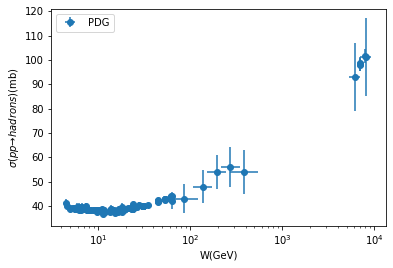

In [5]:
plotSigma([data], ["PDG"])

In [6]:
def chi2(x, data_frame):
    """
        Computes the chi2 given data in data_frame and two parameters a and b
        chi2 = sum (sigmaPred - sigmaExp)^2 / (sqrt(deltaSigmaExp**2 + deltaSigmaW**2))
        where deltaSigmaW is the uncertainty due to the independent variable W
        x = a, b, c
    """
    a = x[0]
    b = x[1]
    c = x[2]
    #j0 = x[3]
    #j1 = x[2]
    #j2 = x[3]
    # Compute sigma using W as the central value
    sigma_central = sigmaPred(data_frame["W(GeV)"], a, b, c)
    #sigma_central = sigmaPred(data_frame["W(GeV)"], b, c)
    # Compute sigma using W as the central values plus the positive error
    sigma_plus = sigmaPred(data_frame["W(GeV)"] + data_frame["WErrorp"], a, b, c)
    #sigma_plus = sigmaPred(data_frame["W(GeV)"] + data_frame["WErrorp"], b, c)
    # Compute sigma using W as the central value minus the negative error
    sigma_minus = sigmaPred(data_frame["W(GeV)"] - data_frame["WErrorm"], a, b, c)
    #sigma_minus = sigmaPred(data_frame["W(GeV)"] - data_frame["WErrorm"], b, c)
    deltaSigmaW = np.minimum(np.abs(sigma_plus - sigma_central),np.abs(sigma_central - sigma_minus))
    deltaSigmaExp = np.maximum(data_frame["Errorp"], data_frame["Errorm"])
    s = (sigma_central - data_frame["sigma(mb)"])**2 / (deltaSigmaW ** 2 + deltaSigmaExp ** 2)
    return np.sum(s)

Best fit parameters: a, b, c = 0.010224, 21.813334, 51.687708
The chi2 / N.d.o.f =  1.2300884855913536


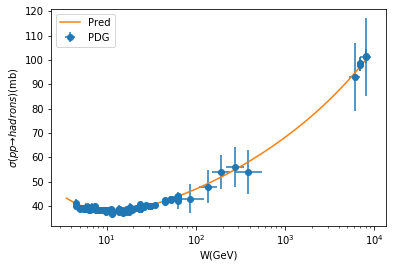

In [7]:
# fit the model
# Start the fit
x0 = np.array([0.004531, 21.864026, 50.723341])
best_fit_x = minimize(chi2, x0, args = data, method = "Nelder-Mead", tol = 1e-6).x
print("Best fit parameters: a, b, c = %f, %f, %f" % (best_fit_x[0], best_fit_x[1], best_fit_x[2]))
chi2_ndof = chi2(best_fit_x, data) / (len(data) - len(best_fit_x))
print("The chi2 / N.d.o.f = ", chi2_ndof)
# Now we plot the prediction
Ws = np.linspace(data["W(GeV)"].min() - 1, data["W(GeV)"].max() + 1, 10000)
sigma = sigmaPred(Ws, best_fit_x[0], best_fit_x[1], best_fit_x[2])
pred_df = pd.DataFrame({"W(GeV)":Ws, "sigma(mb)":sigma})
plotSigma([data, pred_df], ["PDG", "Pred"])

In [8]:
# Now let's analyse what are the points giving me trouble
# We will identify them by computing the weighted square difference of each point
a, b, c = best_fit_x[0], best_fit_x[1], best_fit_x[2]
# Compute sigma using W as the central value
sigma_central = sigmaPred(data["W(GeV)"], a, b, c)
# Compute sigma using W as the central values plus the positive error
sigma_plus = sigmaPred(data["W(GeV)"] + data["WErrorp"], a, b, c)
# Compute sigma using W as the central value minus the negative error
sigma_minus = sigmaPred(data["W(GeV)"] - data["WErrorm"], a, b, c)
deltaSigmaW = np.maximum(np.abs(sigma_plus - sigma_central),np.abs(sigma_central - sigma_minus))
deltaSigmaExp = np.maximum(data["Errorp"], data["Errorm"])
s = np.array((sigma_central - data["sigma(mb)"])**2 / (deltaSigmaW ** 2 + deltaSigmaExp ** 2))